<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/googlenet(inception-v1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GoogLeNet (Inception-v1) on Imagenette**

> *Szegedy, Christian et al. “Going deeper with convolutions.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (2014): 1-9.* <br>
![citation](https://img.shields.io/badge/dynamic/json?label=Citations&query=citationCount&url=https%3A%2F%2Fapi.semanticscholar.org%2Fgraph%2Fv1%2Fpaper%2Fe15cf50aa89fee8535703b9f9512fca5bfc43327%3Ffields%3DcitationCount&style=flat-square)

In this notebook, we show how to train a GoogLeNet from scratch and implement some other features and setting in the original work.



[GoogLeNet](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf), known as the winner of **ILSVRC (ImageNet Large Scale Visual Recognition Competition)** in 2014, has a **6.67% top-5** error rate, significantly outperforming ZFNet (the winner in 2013, top-5 error 11.7%) and AlexNet (the winner in 2012, top-5 error 16.4%).

One key feature of GoogLeNet's architecture is the **inception** block that consists of convolution layers of different sizes and max-pooling layer in a parallel fashion. The team named this structure after the science fiction directed by Christopher Nolan for they were inspired by this [internet meme](https://knowyourmeme.com/memes/we-need-to-go-deeper):

![WeNeedToGoDeeper](https://i.kym-cdn.com/photos/images/original/000/531/557/a88.jpg)

# **Section 1. Set up**

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.2 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

# Mount your google drive to save training checkpoints.
drive.mount('/content/gdrive')

# Prepare directory for PATH.
directory = f"/content/gdrive/MyDrive/Colab Checkpoints/GoogLeNet-v1/"
if not os.path.exists(directory):
  os.makedirs(directory)
PATH = directory + "state_dict.ckpt"

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset


**Dataset**

In this demostration, we are going to use the dataset **Imagenette**, a subset of Imagenet dataset with 10 classes, to train and validate the GoogLeNet-v1 architecture. We can download this dataset by simply calling **fast.ai** API.

In [ ]:
from torchvision.datasets import ImageFolder
from fastai.vision.all import URLs, untar_data

root = untar_data(URLs.IMAGENETTE)
print("Root directory:", root)

train_dataset = ImageFolder(str(root)+"/train")

# Generate indices to permute the training data and conduct train-test-split
total_size = len(train_dataset)
valid_size = total_size // 5
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

Root directory: /root/.fastai/data/imagenette2


As they mentioned in the paper, "*The size of the receptive field in our network is 224 x 224 in the RGB color space with zero mean.*" We start with substracting the mean of RGB color in each image and resize the images into size of 224 after we apply further transformations.

Calculating the mean from the training set takes around a minute.To accerlerate the process, the values are given as magic numbers in the following cell. You may want to verify the calculation by running those comments.

In [ ]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Get mean RGB value, computed on the training set
train_dataset = ImageFolder(str(root)+"/train", transform=ToTensor())
train_dataset = Subset(train_dataset, indices[:-valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=1)

# sum = torch.zeros(3)
# for data, _ in train_dataloader:
#   sum = sum + data.mean(axis=(0, 2, 3))
# mean = sum / len(train_dataloader)

mean = torch.tensor([0.4631, 0.4591, 0.4305])
print("Mean:", mean)

Mean: tensor([0.4631, 0.4591, 0.4305])


**Data Augmentations in Training Stage and Testing Stage**

-----


**Training Stage**

The GoogLeNet team used various sampling and cropping strategy during the ILSVRC 2014 competetion without providing so many details in the paper except one prescription: 
> Include sampling of various sized patches of the image whose size is distributed evenly between 8% and 100% of the image area with aspect ratio constrained to the interval \[0.75, 1.33\]

However, I decide not to implement this sampling procedure in this notebook for it adds too much complexity in this demostration. I simply do random crop with size 224 and apply photometric distortions [(Andrew Howard, 2013)](https://arxiv.org/abs/1312.5402), as the GoogLeNet team applied during the data augmentation stage, to those sampled crops.

**Testing Stage**

Thet adopted a more aggressive cropping approach.

>  Specifically, we resized the image to 4 scales where the
shorter dimension (height or width) is 256, 288, 320 and 352 respectively, take the left, center and right square of these resized images (in the case of portrait images, we take the top, center and bottom squares). 

Only size 256 will be done in this notebook. The cropping strategy mentioned here is implemented as the custom `ThreeCrop()` transformation.

> For each square, we then take the 4 corners and the center 224x224 crop as well as the square resized to 224x224, and their mirrored versions.  ...

A custom `TwelveCrop()` transformation is implemented for this sampling procedure. The prediction of a image are generated based on the average softmax probability of the 3*12=36 crops.



In [ ]:
from torchvision.transforms import (
    Compose, RandomCrop, Resize, ColorJitter, Normalize, Lambda
)
from torchvision.transforms.functional import crop, ten_crop, resize, hflip

normalize = Normalize(mean, [1., 1., 1.])

class ThreeCrop(nn.Module):
    def forward(self, img):
      """
      Args:
          img (Tensor): Image to be cropped.
      Returns:
          tuple of 3 images.
      """
      c, h, w = img.size()
      
      # protrait
      if h >= w: 
          top    = crop(img, 0, 0, w, w)
          center = crop(img, (h-w)//2, 0, w, w)
          bottom = crop(img, h-w, 0, w, w)
          return top, center, bottom
      
      # landscape
      else:      
          left   = crop(img, 0, 0, h, h)
          center = crop(img, 0, (w-h)//2, h, h)
          right  = crop(img, 0, w-h, h, h)
          return left, center, right


class TwelveCrop(nn.Module):
    def __init__(self, size=224):
        super().__init__()
        self.size = (size, size) if size is int else size
    
    def forward(self, img):
        """
        Args:
            img (Tensor): Image to be cropped.
        Returns:
            tuple of 12 images.
        """
        return ten_crop(img, self.size) + (resize(img, self.size), resize(hflip(img), self.size))    

In [ ]:
## Training Set
train_tfms = Compose([
    ToTensor(),
    normalize,                      # Subtract the mean RGB value
    Resize(256),                   
    RandomCrop(224),                # Crop images to fixed-size 224 x 224
    ColorJitter(brightness = .5,
                contrast = .5,
                saturation =.5, 
                hue = .5)           # Augmentation: photometric distortion
])

train_dataset = ImageFolder(str(root)+"/train", transform=train_tfms)
train_dataset = Subset(train_dataset, indices[:-valid_size])


## Validation Set and Testing Set
test_tfms = Compose([
    ToTensor(),
    normalize,
    Resize(256),
    ThreeCrop(),
    Lambda(lambda crops: torch.stack(crops)),
    TwelveCrop(size=224),
    Lambda(lambda crops: torch.vstack(crops))
])

valid_dataset = ImageFolder(str(root)+"/train", transform=test_tfms)
valid_dataset = Subset(valid_dataset, indices[-valid_size:])

test_dataset = ImageFolder(str(root)+"/val", transform=test_tfms)

print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Validation image: ", valid_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)


Data Size:
* Training set   =>  7576 images
* Validation set =>  1893 images
* Testing set    =>  3925 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 224, 224])
* Validation image:  torch.Size([36, 3, 224, 224])
* Testing image:  torch.Size([36, 3, 224, 224])


**Check Testing data Augmentation**

Let's print out the images in the testing data to see if we crop them correctly. Everything look perfect here. Note that we generate 36 patches of image from 1 original image.

Original image:


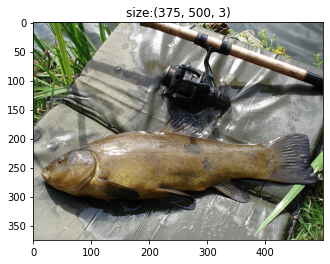


Transformed image (w/ mean recovered):


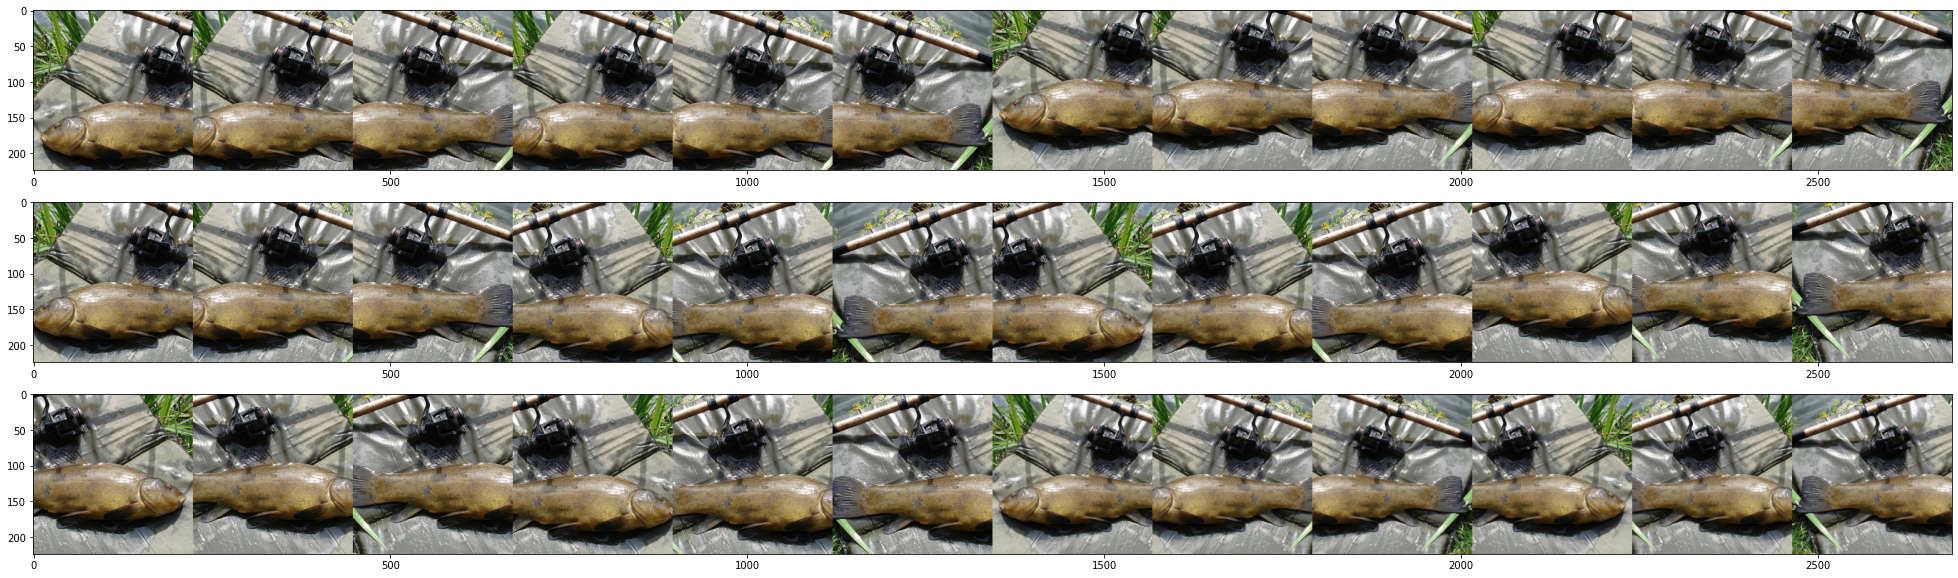

In [ ]:
from einops import rearrange
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread(test_dataset.imgs[0][0])
plt.title(f"size:{img.shape}")
imgplot = plt.imshow(img)
print("Original image:")
plt.show()

fig, ax = plt.subplots(3, 1, figsize=(72, 10))
for i in range(len(ax)):
  imgs = torch.dstack([test_dataset[0][0][i]+mean.reshape(3, 1, 1) for i in range(12*i, 12*(i+1))])
  imgs = rearrange(imgs, "C H W -> H W C")
  ax[i].imshow(imgs)
print("\nTransformed image (w/ mean recovered):")
plt.show()

### **Dataloaders**

We set training batch size = 128 for the sake of available GPU memory of free Colab. As for validation and testing, we set the batch size = 1 to load the images one by one since we should calculate the mean probability of each image from its patches.


In [ ]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
image, target = next(iter(valid_dataloader))
print(f"{'Validation image shape:':25}", image.shape)
print(f"{'Validation target shape:':25}", target.shape)
image, target = next(iter(test_dataloader))
print(f"{'Test image shape:':25}", image.shape)
print(f"{'Test target shape:':25}", target.shape)
del image, target

Validation image shape:   torch.Size([1, 36, 3, 224, 224])
Validation target shape:  torch.Size([1])
Test image shape:         torch.Size([1, 36, 3, 224, 224])
Test target shape:        torch.Size([1])


There is one additional dimension attached in the front of tensor as dataloader is called ! This feature is called [Automatic batching](https://pytorch.org/docs/stable/data.html#automatic-batching-default).

Here we should customize a `collate_fn` to obtain the result we want:

In [ ]:
from torch.utils.data._utils.collate import collate, collate_int_fn

def collate_tensor_fn(batch, *, collate_fn_map):
    return batch[0]

def custom_collate(batch):
    collate_map = dict()
    collate_map[torch.Tensor] = collate_tensor_fn
    collate_map[int] = collate_int_fn
    return collate(batch, collate_fn_map=collate_map)


valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False,
                              pin_memory=True, collate_fn=custom_collate)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             pin_memory=True, collate_fn=custom_collate)

In [ ]:
image, target = next(iter(valid_dataloader))
print(f"{'Validation image shape:':25}", image.shape)
print(f"{'Validation target shape:':25}", target.shape)
image, target = next(iter(test_dataloader))
print(f"{'Test image shape:':25}", image.shape)
print(f"{'Test target shape:':25}", target.shape)
del image, target

Validation image shape:   torch.Size([36, 3, 224, 224])
Validation target shape:  torch.Size([1])
Test image shape:         torch.Size([36, 3, 224, 224])
Test target shape:        torch.Size([1])


### HyperModule

With Pytorch, we need to write the training loop (back proporgation) and the testing function on our own. To make the whole process look tidy in this notebook, I write a simple **wrapper class** to collect all these work, which is [`HyperModule`](https://github.com/kevinkevin556/Dlchemist/tree/main/hypermodule). One can find out more details about `HyperModule` and customize it for your pytorch project based on [source code](https://github.com/kevinkevin556/Dlchemist/blob/main/hypermodule/hypermodule.py) from my repo.

In [ ]:
!gdown https://github.com/kevinkevin556/Dlchemist/raw/main/hypermodule/hypermodule.py
from hypermodule import HyperModule

Downloading...
From: https://github.com/kevinkevin556/Dlchemist/raw/main/hypermodule/hypermodule.py
To: /content/hypermodule.py
8.60kB [00:00, 14.3MB/s]       


There are a few modifications we should do to our hypermodule for GoogLeNet:

* **Add losses from auxilary classifiers** ⇒ Override the method for back proporgation: **`update_()`**
* **Take average probabilities of 36 crops** ⇒ Override the method that generates prediction labels: **`get_prediction_()`**
* Override **`validate()`** to validate trained model using 1/3 of the validation data since testing is expensive with so many crops for one image.

In [ ]:
from torch.nn.functional import softmax

class HyperModuleG(HyperModule):
  
    def update_(self, images, targets):
        preds = self.model(images)
        loss = 0.3 * self.criterion(preds[0], targets) + \
               0.3 * self.criterion(preds[1], targets) + \
               self.criterion(preds[2], targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_loss.append(loss.detach().item())
       
    def get_prediction_(self, images, targets, validation=True):
        preds = self.model(images)
        probs = torch.mean(softmax(preds, dim=1), dim=0)   # Here we take the average of softmax prob of 36 crops of an image,
                                                           # note we should set batch size = 1. 
        pred_labels = torch.argmax(probs, dim=-1)
        if validation:
            return pred_labels
        else:
            pred_labels = pred_labels.view(-1).detach().cpu().numpy()
            targets = targets.view(-1).detach().cpu().numpy()
            return pred_labels, targets
  
    def validate(self, dataloader):
        device = torch.device('cuda')
        self.model.to(device)
        self.model.eval()
        batch_acc = []
        n, num_validation = 0, len(dataloader)//3
        with torch.no_grad():
            for images, targets in dataloader:
                images, targets = images.to(device), targets.to(device)
                pred_labels = self.get_prediction_(images, targets, validation=True)
                batch_acc.append((pred_labels == targets).type(torch.float32).mean().item())
                
                n += 1
                if n == num_validation:
                    break
        return batch_acc


### Network Architecture

#### **Inception**

We introduce Inception block first for it is the most well-known feature of GoogLeNet. In an Inception module, 
* 1x1 convolutions
* 3x3 convolutions
* 5x5 convolutions
* 3x3 max-pooling

are performed simultaneously on the input and the results are combined to form the final output. The notion is that using convolution filters of different sizes will enhance the ability to detect objects at various scales.


![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*sezFsYW1MyM9YOMa1q909A.png)

In [ ]:
from einops import rearrange, reduce
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, Sequential,
    Flatten, Linear, Softmax, AvgPool2d,
    Dropout
)

class Inception(nn.Module):
  def __init__(self, in_channels, conv1, conv3, conv5, pool_proj):
    super().__init__()
    # 1x1 convolution branch
    conv1_out = conv1
    self.conv1x1 = Sequential(
        Conv2d(in_channels, conv1_out, kernel_size=1),           ReLU()
    )
    # 3x3 convolution branch
    conv3_red, conv3_out = conv3
    self.conv3x3 = Sequential(
        Conv2d(in_channels, conv3_red, kernel_size=1),           ReLU(),
        Conv2d(conv3_red, conv3_out, kernel_size=3, padding=1),  ReLU()
    )
    # 5x5 convolution branch
    conv5_red, conv5_out = conv5
    self.conv5x5 = Sequential(
        Conv2d(in_channels, conv5_red, kernel_size=1),           ReLU(),
        Conv2d(conv5_red, conv5_out, kernel_size=5, padding=2),  ReLU()
    )
    # Max-pool branch
    pool_proj_out = pool_proj
    self.max_pool = Sequential(
        MaxPool2d(kernel_size=3, stride=1, padding=1),
        Conv2d(in_channels, pool_proj_out, kernel_size=1),       ReLU()
    )

    self.out_channels = conv1_out + conv3_out + conv5_out + pool_proj_out 
  
  def forward(self, x):
    out1x1 = self.conv1x1(x)
    out3x3 = self.conv3x3(x)
    out5x5 = self.conv5x5(x)
    out_pool = self.max_pool(x)
    out = torch.hstack([out1x1, out3x3, out5x5, out_pool])
    return out

#### **Architecture**

<img src="https://github.com/kevinkevin556/Dlchemist/raw/main/images/architecture/googlenet.svg" alt="drawing" width="1250" height="350"/>

Besides Inception module, GoogLeNet leverges these design to reach a high level of performance: **1x1 convolutions**, **global average pooling** and **auxiliary classifiers**. 1x1 convolutions and global average pooling were firstly proposed in the work of [[Lin, Chen and Yan, 2013]](https://arxiv.org/abs/1312.4400), which known as **Network in Network**. 

---

**The 1×1 Convolution**

In the original work [[Lin, Chen and Yan, 2013]](https://arxiv.org/abs/1312.4400), they regarded 1x1 convolutions as an universal function approximator for feature extraction, that is, a powerful activation function (**nonlinearity**) from the GLM viewpoint. However, the GoogLeNet team discovered one another usage of 1x1 convolutions: **dimension reduction**.

For example, 

- {28 x 28 x 192} convolved with 32 `Conv2d(192, 32, kernel_size=5, padding=2)` kernels into {28 x 28 x 32}
    - \# multiplications = (5 x 5 x 192) muls x (28 x 28) pixels x 32 kernels ~ **120M**
- {28 x 28 x 192} convolved with 16 [`Conv2d(192, 16, kernel_size=1)`]() kernels into {28 x 28 x 16}, followed by convolution with into 32 `Conv2d(16, 32, kernel_size=5, padding=2)` kernels into {28 x 28 x 32}
 -  92 mul x (28 x 28) pixels x 16 kernels ~ 2.4M
 -  (5 x 5 x 16) muls x (28 x 28) pixels x 32 kernels ~ 10M
 - \# multiplications = **12.4M**

**Global Average Pooling**

For inputs of image types, it is native to introduce locality induction bias when designing neural network. While FC layers are prone to overfiting, a global average pooling layer with convolution structure can enforce correspondences between feature maps and categories, and improve generalization ability.

**Auxiliary Classifiers**

Auxiliary classifiers generate loss besides the main branch to help optimize the learning process of neural networks. According to the paper, 

> By adding auxiliary classifiers connected to these intermediate layers, discrimination in the lower stages in the classifier was expected. This was
thought to **combat the vanishing gradient problem** while providing regularization.

Losses of auxilary classifiers are added to the total loss of the network
with a discount weight of 0.3 during training. The auxiliary classifiers are not activated in the inference stage.

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net0 = Sequential(
        Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  ReLU(),
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Conv2d(64, 192, kernel_size=3, stride=1, padding=1),  ReLU(),
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(192, conv1=64,  conv3=(96, 128),  conv5=(16, 32), pool_proj=32),    # 3a
        Inception(256, conv1=128, conv3=(128, 192), conv5=(32, 96), pool_proj=64),    # 3b
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(480, conv1=192, conv3=(96, 208),  conv5=(16, 48), pool_proj=64),    # 4a
    )
    self.net1 = Sequential(    
        Inception(512, conv1=160, conv3=(112, 224), conv5=(24, 64), pool_proj=64),    # 4b
        Inception(512, conv1=128, conv3=(128, 256), conv5=(24, 64), pool_proj=64),    # 4c
        Inception(512, conv1=112, conv3=(144, 288), conv5=(32, 64), pool_proj=64),    # 4d
    )
    self.net2 = Sequential(
        Inception(528, conv1=256, conv3=(160, 320), conv5=(32, 128), pool_proj=128),  # 4e
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(832, conv1=256, conv3=(160, 320), conv5=(32, 128), pool_proj=128),  # 5a
        Inception(832, conv1=384, conv3=(112, 384), conv5=(48, 128), pool_proj=128),  # 5b
        AvgPool2d(kernel_size=7, stride=1),
        Dropout(p=0.4),
        Flatten(),
        Linear(1024, num_classes)
    )
    self.aux_classifier0 = Sequential(
        AvgPool2d(kernel_size=5, stride=3),
        Conv2d(512, 128, kernel_size=1),          ReLU(),
        Flatten(),
        Linear(4*4*128, 1024),                    ReLU(),
        Dropout(p=0.7),
        Linear(1024, num_classes)
    )
    self.aux_classifier1 = Sequential(
        AvgPool2d(kernel_size=5, stride=3),
        Conv2d(528, 128, kernel_size=1),          ReLU(),
        Flatten(),
        Linear(4*4*128, 1024),                    ReLU(),
        Dropout(p=0.7),
        Linear(1024, num_classes)
    )
    self.train_state = True


  def forward(self, x):
    if self.train_state:
      x = self.net0(x)
      out0 = self.aux_classifier0(x)
      x = self.net1(x)
      out1 = self.aux_classifier1(x)
      out2 = self.net2(x)
      return out0, out1, out2
    else: 
      x = self.net0(x)
      x = self.net1(x)
      out = self.net2(x)
      return out


  def train(self, mode=True):
    self.train_state = mode
    super().train(mode)
    return self

In [ ]:
# Check Forward Path: Training
X = torch.randn(1, *train_dataset[0][0].shape)
model = GoogLeNet()
model.eval()
print(f"{'Image shape:':25s} {list(X.shape)}")
for net in [model.net0, model.net1, model.net2]:
    for layer in net:
        X = layer(X)
        print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")
del X, model

Image shape:              [1, 3, 224, 224]
Conv2d output shape:      [1, 64, 112, 112]
ReLU output shape:        [1, 64, 112, 112]
MaxPool2d output shape:   [1, 64, 56, 56]
Conv2d output shape:      [1, 192, 56, 56]
ReLU output shape:        [1, 192, 56, 56]
MaxPool2d output shape:   [1, 192, 28, 28]
Inception output shape:   [1, 256, 28, 28]
Inception output shape:   [1, 480, 28, 28]
MaxPool2d output shape:   [1, 480, 14, 14]
Inception output shape:   [1, 512, 14, 14]
Inception output shape:   [1, 512, 14, 14]
Inception output shape:   [1, 512, 14, 14]
Inception output shape:   [1, 528, 14, 14]
Inception output shape:   [1, 832, 14, 14]
MaxPool2d output shape:   [1, 832, 7, 7]
Inception output shape:   [1, 832, 7, 7]
Inception output shape:   [1, 1024, 7, 7]
AvgPool2d output shape:   [1, 1024, 1, 1]
Dropout output shape:     [1, 1024, 1, 1]
Flatten output shape:     [1, 1024]
Linear output shape:      [1, 10]


**Test training output and testing output**

We find the final output in training state is different from the one generated in testing/validation state. It is because dropout layers are used in the GoogLeNet. One can comment out the dropout layers to verify that two outputs match without err.

In [ ]:
X = torch.zeros(1, *train_dataset[0][0].shape)
model = GoogLeNet()
out = model(X)
print("Training output:", out[2].detach())
print("\nIntermediate output 0 shape:", out[0].detach())
print("Intermediate output 1 shape:", out[1].detach())

model.eval()
out = model(X)
print("\nTesting output:", out.detach())

del X, model

Training output: tensor([[ 0.0125,  0.0078, -0.0046,  0.0328, -0.0016,  0.0118,  0.0016, -0.0122,
          0.0041, -0.0356]])

Intermediate output 0 shape: tensor([[ 0.0151,  0.0275,  0.0176, -0.0245, -0.0044, -0.0074,  0.0357, -0.0346,
          0.0051,  0.0082]])
Intermediate output 1 shape: tensor([[-0.0151, -0.0042, -0.0056, -0.0198,  0.0338,  0.0163, -0.0059, -0.0235,
          0.0298, -0.0505]])

Testing output: tensor([[ 0.0056,  0.0057, -0.0083,  0.0218, -0.0096,  0.0128,  0.0008, -0.0192,
          0.0041, -0.0350]])


#### **A smaller architecture**

If you work on this dataset with the original GoogLeNet architecture, you may find it overfits easily. The reason is that the original model is too big for  this very small subset of ImageNet. Therefore, I create a smaller version by omitting some convolution layers and Inception modules.

In [ ]:
class GoogLeNetM(GoogLeNet):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net0 = Sequential(
        Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  ReLU(),
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(64, conv1=64,  conv3=(96, 128),  conv5=(16, 32), pool_proj=32),
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(256, conv1=192, conv3=(96, 208),  conv5=(16, 48), pool_proj=64),
    )
    self.net1 = Sequential(
        Inception(512, conv1=128, conv3=(128, 256), conv5=(24, 64), pool_proj=64),
    )
    self.net2 = Sequential(
        Inception(512, conv1=256, conv3=(160, 320), conv5=(32, 128), pool_proj=128),
        MaxPool2d(kernel_size=3, stride=2, padding=1),
        Inception(832, conv1=384, conv3=(112, 384), conv5=(48, 128), pool_proj=128),
        AvgPool2d(kernel_size=14, stride=1),
        Dropout(p=0.4),
        Flatten(),
        Linear(1024, num_classes)
    )
    self.aux_classifier0 = Sequential(
        AvgPool2d(kernel_size=5, stride=3),
        Conv2d(512, 128, kernel_size=1),          ReLU(),
        Flatten(),
        Linear(8*8*128, num_classes)
    )
    self.aux_classifier1 = Sequential(
        AvgPool2d(kernel_size=5, stride=3),
        Conv2d(512, 128, kernel_size=1),          ReLU(),
        Flatten(),
        Linear(8*8*128, num_classes)
    )
    self.train_state = True

In [ ]:
# Check Forward Path: Training
X = torch.randn(1, *train_dataset[0][0].shape)
model = GoogLeNetM()
model.eval()
print(f"{'Image shape:':25s} {list(X.shape)}")
for net in [model.net0, model.net1, model.net2]:
    for layer in net:
        X = layer(X)
        print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")
    print("------")
del X, model

Image shape:              [1, 3, 224, 224]
Conv2d output shape:      [1, 64, 112, 112]
ReLU output shape:        [1, 64, 112, 112]
MaxPool2d output shape:   [1, 64, 56, 56]
Inception output shape:   [1, 256, 56, 56]
MaxPool2d output shape:   [1, 256, 28, 28]
Inception output shape:   [1, 512, 28, 28]
------
Inception output shape:   [1, 512, 28, 28]
------
Inception output shape:   [1, 832, 28, 28]
MaxPool2d output shape:   [1, 832, 14, 14]
Inception output shape:   [1, 1024, 14, 14]
AvgPool2d output shape:   [1, 1024, 1, 1]
Dropout output shape:     [1, 1024, 1, 1]
Flatten output shape:     [1, 1024]
Linear output shape:      [1, 10]
------


In [ ]:
X = torch.zeros(1, *train_dataset[0][0].shape)
model = GoogLeNetM()
out = model(X)
print("Training output:", out[2].detach())
print("\nIntermediate output 0 shape:", out[0].detach())
print("Intermediate output 1 shape:", out[1].detach())

model.eval()
out = model(X)
print("\nTesting output:", out.detach())

del X, model

Training output: tensor([[-0.0227, -0.0204,  0.0204, -0.0211,  0.0006,  0.0134, -0.0299, -0.0434,
         -0.0037, -0.0303]])

Intermediate output 0 shape: tensor([[ 0.0230, -0.0125, -0.0024,  0.0015, -0.0091, -0.0084, -0.0100, -0.0080,
         -0.0024, -0.0061]])
Intermediate output 1 shape: tensor([[ 0.0193, -0.0301, -0.0040, -0.0143, -0.0056, -0.0244, -0.0162,  0.0085,
         -0.0160,  0.0158]])

Testing output: tensor([[-0.0159, -0.0087,  0.0317, -0.0123,  0.0160,  0.0144, -0.0233, -0.0455,
          0.0027, -0.0141]])


# **Section 2. Start Training**

### First 10 Epoches

In [ ]:
BASE_LR = 0.001
NUM_EPOCHS = 10

In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), BASE_LR)
# optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.train(train_dataloader, valid_dataloader, save_path=PATH, num_epochs=NUM_EPOCHS)

Epoch [1/10]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=3.28]


Train Loss: 3.609, Valid Acc:0.143
State dict saved.


Epoch [2/10]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=3.28]


Train Loss: 3.402, Valid Acc:0.151
State dict saved.


Epoch [3/10]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=3.69]


Train Loss: 3.265, Valid Acc:0.192
State dict saved.


Epoch [4/10]: 100%|██████████| 60/60 [02:43<00:00,  2.73s/it, loss=3.22]


Train Loss: 3.177, Valid Acc:0.214
State dict saved.


Epoch [5/10]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=3]


Train Loss: 3.054, Valid Acc:0.239
State dict saved.


Epoch [6/10]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=2.67]


Train Loss: 2.916, Valid Acc:0.360
State dict saved.


Epoch [7/10]: 100%|██████████| 60/60 [02:42<00:00,  2.70s/it, loss=2.73]


Train Loss: 2.756, Valid Acc:0.290


Epoch [8/10]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=2.26]


Train Loss: 2.673, Valid Acc:0.363
State dict saved.


Epoch [9/10]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=2.46]


Train Loss: 2.569, Valid Acc:0.341


Epoch [10/10]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=2.6]


Train Loss: 2.497, Valid Acc:0.434
State dict saved.


### 100 Epoches

In [ ]:
#@title
hm.train(train_dataloader, valid_dataloader, save_path=PATH, num_epochs=90)

Epoch [11/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=2.1]


Train Loss: 2.384, Valid Acc:0.480
State dict saved.


Epoch [12/100]: 100%|██████████| 60/60 [02:40<00:00,  2.67s/it, loss=2.05]


Train Loss: 2.245, Valid Acc:0.483
State dict saved.


Epoch [13/100]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=2.56]


Train Loss: 2.222, Valid Acc:0.388


Epoch [14/100]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=2.54]


Train Loss: 2.152, Valid Acc:0.501
State dict saved.


Epoch [15/100]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=2.1]


Train Loss: 2.103, Valid Acc:0.448


Epoch [16/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=2.55]


Train Loss: 1.989, Valid Acc:0.472


Epoch [17/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=2.27]


Train Loss: 1.984, Valid Acc:0.393


Epoch [18/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=2.08]


Train Loss: 1.884, Valid Acc:0.341


Epoch [19/100]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=1.18]


Train Loss: 1.819, Valid Acc:0.433


Epoch [20/100]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=2.25]


Train Loss: 1.808, Valid Acc:0.374


Epoch [21/100]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=1.24]


Train Loss: 1.749, Valid Acc:0.388


Epoch [22/100]: 100%|██████████| 60/60 [02:39<00:00,  2.65s/it, loss=1.38]


Train Loss: 1.667, Valid Acc:0.515
State dict saved.


Epoch [23/100]: 100%|██████████| 60/60 [02:39<00:00,  2.65s/it, loss=1.96]


Train Loss: 1.647, Valid Acc:0.485


Epoch [24/100]: 100%|██████████| 60/60 [02:39<00:00,  2.65s/it, loss=2.21]


Train Loss: 1.630, Valid Acc:0.574
State dict saved.


Epoch [25/100]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=1.97]


In [ ]:
#@title
BASE_LR = 0.001
NUM_EPOCHS = 100

googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), BASE_LR)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [28/100]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=2.42]


Train Loss: 1.527, Valid Acc:0.523


Epoch [29/100]: 100%|██████████| 60/60 [02:43<00:00,  2.72s/it, loss=1.5]


Train Loss: 1.471, Valid Acc:0.494


Epoch [30/100]: 100%|██████████| 60/60 [02:43<00:00,  2.72s/it, loss=1.56]


Train Loss: 1.406, Valid Acc:0.647
State dict saved.


Epoch [31/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.897]


Train Loss: 1.390, Valid Acc:0.485


Epoch [32/100]: 100%|██████████| 60/60 [02:43<00:00,  2.73s/it, loss=1.95]


Train Loss: 1.344, Valid Acc:0.659
State dict saved.


Epoch [33/100]: 100%|██████████| 60/60 [02:40<00:00,  2.67s/it, loss=1.01]


Train Loss: 1.342, Valid Acc:0.561


Epoch [34/100]: 100%|██████████| 60/60 [02:39<00:00,  2.65s/it, loss=1.44]


Train Loss: 1.349, Valid Acc:0.564


Epoch [35/100]: 100%|██████████| 60/60 [02:37<00:00,  2.62s/it, loss=0.645]


Train Loss: 1.275, Valid Acc:0.578


Epoch [36/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=1.2]


Train Loss: 1.254, Valid Acc:0.493


Epoch [37/100]: 100%|██████████| 60/60 [02:38<00:00,  2.65s/it, loss=1.52]


Train Loss: 1.259, Valid Acc:0.596


Epoch [38/100]: 100%|██████████| 60/60 [02:37<00:00,  2.63s/it, loss=1.11]


Train Loss: 1.231, Valid Acc:0.599


Epoch [39/100]: 100%|██████████| 60/60 [02:38<00:00,  2.65s/it, loss=1.25]


Train Loss: 1.227, Valid Acc:0.707
State dict saved.


Epoch [40/100]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=1.33]


Train Loss: 1.165, Valid Acc:0.574


Epoch [41/100]: 100%|██████████| 60/60 [02:39<00:00,  2.66s/it, loss=1.14]


Train Loss: 1.182, Valid Acc:0.721
State dict saved.


Epoch [42/100]: 100%|██████████| 60/60 [02:38<00:00,  2.64s/it, loss=1.42]


Train Loss: 1.146, Valid Acc:0.640


Epoch [43/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=1.41]


Train Loss: 1.147, Valid Acc:0.702


Epoch [44/100]: 100%|██████████| 60/60 [02:35<00:00,  2.60s/it, loss=1.22]


Train Loss: 1.103, Valid Acc:0.609


Epoch [45/100]: 100%|██████████| 60/60 [02:36<00:00,  2.60s/it, loss=1.15]


Train Loss: 1.089, Valid Acc:0.670


Epoch [46/100]: 100%|██████████| 60/60 [02:38<00:00,  2.64s/it, loss=1.15]


Train Loss: 1.035, Valid Acc:0.678


Epoch [47/100]: 100%|██████████| 60/60 [02:37<00:00,  2.62s/it, loss=1.03]


Train Loss: 1.050, Valid Acc:0.662


Epoch [48/100]: 100%|██████████| 60/60 [02:37<00:00,  2.63s/it, loss=0.657]


Train Loss: 1.016, Valid Acc:0.713


Epoch [49/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=0.553]


Train Loss: 0.984, Valid Acc:0.648


Epoch [50/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=1.39]


Train Loss: 1.032, Valid Acc:0.686


Epoch [51/100]: 100%|██████████| 60/60 [02:37<00:00,  2.62s/it, loss=0.721]


Train Loss: 1.035, Valid Acc:0.710


Epoch [52/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=0.9]


Train Loss: 0.953, Valid Acc:0.686


Epoch [53/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=1.06]


Train Loss: 0.973, Valid Acc:0.716


Epoch [54/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=0.559]


Train Loss: 0.932, Valid Acc:0.688


Epoch [55/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=1]


Train Loss: 0.900, Valid Acc:0.748
State dict saved.


Epoch [56/100]: 100%|██████████| 60/60 [02:37<00:00,  2.62s/it, loss=0.93]


Train Loss: 0.922, Valid Acc:0.723


Epoch [57/100]: 100%|██████████| 60/60 [02:36<00:00,  2.60s/it, loss=0.275]


Train Loss: 0.879, Valid Acc:0.758
State dict saved.


Epoch [58/100]: 100%|██████████| 60/60 [02:36<00:00,  2.62s/it, loss=1.12]


Train Loss: 0.847, Valid Acc:0.726


Epoch [59/100]: 100%|██████████| 60/60 [02:36<00:00,  2.61s/it, loss=0.547]


Train Loss: 0.823, Valid Acc:0.721


Epoch [60/100]:  68%|██████▊   | 41/60 [01:50<00:50,  2.66s/it, loss=0.787]

In [ ]:
#@title
BASE_LR = 0.001
NUM_EPOCHS = 100

googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), BASE_LR)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [60/100]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=0.632]


Train Loss: 0.841, Valid Acc:0.699


Epoch [61/100]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.424]


Train Loss: 0.817, Valid Acc:0.677


Epoch [62/100]: 100%|██████████| 60/60 [02:50<00:00,  2.84s/it, loss=1.62]


Train Loss: 0.846, Valid Acc:0.762
State dict saved.


Epoch [63/100]: 100%|██████████| 60/60 [02:51<00:00,  2.86s/it, loss=0.767]


Train Loss: 0.803, Valid Acc:0.691


Epoch [64/100]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.666]


Train Loss: 0.751, Valid Acc:0.712


Epoch [65/100]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=1.02]


Train Loss: 0.757, Valid Acc:0.718


Epoch [66/100]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.702]


Train Loss: 0.764, Valid Acc:0.708


Epoch [67/100]: 100%|██████████| 60/60 [02:57<00:00,  2.96s/it, loss=0.538]


Train Loss: 0.737, Valid Acc:0.729


Epoch [68/100]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.722]


Train Loss: 0.804, Valid Acc:0.729


Epoch [69/100]: 100%|██████████| 60/60 [02:45<00:00,  2.75s/it, loss=1.47]


Train Loss: 0.707, Valid Acc:0.786
State dict saved.


Epoch [70/100]: 100%|██████████| 60/60 [02:44<00:00,  2.73s/it, loss=0.658]


Train Loss: 0.703, Valid Acc:0.718


Epoch [71/100]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.685]


Train Loss: 0.682, Valid Acc:0.753


Epoch [72/100]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.477]


Train Loss: 0.700, Valid Acc:0.731


Epoch [73/100]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.925]


Train Loss: 0.682, Valid Acc:0.731


Epoch [74/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=1.33]


Train Loss: 0.672, Valid Acc:0.678


Epoch [75/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=1.2]


Train Loss: 0.684, Valid Acc:0.729


Epoch [76/100]: 100%|██████████| 60/60 [02:43<00:00,  2.72s/it, loss=0.54]


Train Loss: 0.621, Valid Acc:0.723


Epoch [77/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.994]


Train Loss: 0.669, Valid Acc:0.702


Epoch [78/100]: 100%|██████████| 60/60 [02:42<00:00,  2.70s/it, loss=0.842]


Train Loss: 0.634, Valid Acc:0.734


Epoch [79/100]: 100%|██████████| 60/60 [02:43<00:00,  2.73s/it, loss=0.552]


Train Loss: 0.618, Valid Acc:0.732


Epoch [80/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=1.12]


Train Loss: 0.629, Valid Acc:0.754


Epoch [81/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.774]


Train Loss: 0.619, Valid Acc:0.775


Epoch [82/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=0.722]


Train Loss: 0.575, Valid Acc:0.748


Epoch [83/100]: 100%|██████████| 60/60 [02:41<00:00,  2.69s/it, loss=0.497]


Train Loss: 0.648, Valid Acc:0.754


Epoch [84/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.246]


Train Loss: 0.557, Valid Acc:0.735


Epoch [85/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.693]


Train Loss: 0.555, Valid Acc:0.658


Epoch [86/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=0.943]


Train Loss: 0.571, Valid Acc:0.708


Epoch [87/100]: 100%|██████████| 60/60 [02:42<00:00,  2.70s/it, loss=0.581]


Train Loss: 0.569, Valid Acc:0.745


Epoch [88/100]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=0.467]


Train Loss: 0.570, Valid Acc:0.791
State dict saved.


Epoch [89/100]: 100%|██████████| 60/60 [02:41<00:00,  2.70s/it, loss=0.439]


Train Loss: 0.535, Valid Acc:0.745


Epoch [90/100]: 100%|██████████| 60/60 [02:45<00:00,  2.75s/it, loss=0.272]


Train Loss: 0.496, Valid Acc:0.713


Epoch [91/100]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.723]


Train Loss: 0.496, Valid Acc:0.745


Epoch [92/100]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.494]


Train Loss: 0.531, Valid Acc:0.748


Epoch [93/100]: 100%|██████████| 60/60 [02:43<00:00,  2.72s/it, loss=0.664]


Train Loss: 0.508, Valid Acc:0.704


Epoch [94/100]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.462]


Train Loss: 0.512, Valid Acc:0.748


Epoch [95/100]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.657]


Train Loss: 0.504, Valid Acc:0.750


Epoch [96/100]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.574]


Train Loss: 0.494, Valid Acc:0.737


Epoch [97/100]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.46]


Train Loss: 0.459, Valid Acc:0.732


Epoch [98/100]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.503]


Train Loss: 0.465, Valid Acc:0.751


Epoch [99/100]: 100%|██████████| 60/60 [02:42<00:00,  2.70s/it, loss=0.306]


Train Loss: 0.467, Valid Acc:0.700


Epoch [100/100]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.199]


Train Loss: 0.446, Valid Acc:0.754


### 200 Epoches

In [ ]:
NUM_EPOCHS = 200
BASE_LR = 0.001

In [ ]:
#@title
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

Epoch [101/200]: 100%|██████████| 60/60 [03:00<00:00,  3.02s/it, loss=1.01]


Train Loss: 0.495, Valid Acc:0.786


Epoch [102/200]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.329]


Train Loss: 0.507, Valid Acc:0.783


Epoch [103/200]: 100%|██████████| 60/60 [02:43<00:00,  2.73s/it, loss=0.434]


Train Loss: 0.425, Valid Acc:0.765


Epoch [104/200]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.429]


Train Loss: 0.424, Valid Acc:0.748


Epoch [105/200]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.405]


Train Loss: 0.468, Valid Acc:0.750


Epoch [106/200]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.301]


Train Loss: 0.407, Valid Acc:0.740


Epoch [107/200]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.582]


Train Loss: 0.429, Valid Acc:0.677


Epoch [108/200]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.332]


Train Loss: 0.489, Valid Acc:0.705


Epoch [109/200]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.938]


Train Loss: 0.434, Valid Acc:0.704


Epoch [110/200]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.596]


Train Loss: 0.457, Valid Acc:0.693


Epoch [111/200]: 100%|██████████| 60/60 [02:45<00:00,  2.75s/it, loss=0.234]


Train Loss: 0.420, Valid Acc:0.754


Epoch [112/200]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.537]


Train Loss: 0.386, Valid Acc:0.780


Epoch [113/200]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.703]


Train Loss: 0.454, Valid Acc:0.758


Epoch [114/200]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.169]


Train Loss: 0.469, Valid Acc:0.712


Epoch [115/200]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.837]


Train Loss: 0.393, Valid Acc:0.735


Epoch [116/200]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.717]


Train Loss: 0.443, Valid Acc:0.753


Epoch [117/200]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.467]


Train Loss: 0.398, Valid Acc:0.761


Epoch [118/200]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.245]


Train Loss: 0.399, Valid Acc:0.724


Epoch [119/200]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.177]


Train Loss: 0.391, Valid Acc:0.792
State dict saved.


Epoch [120/200]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.594]


Train Loss: 0.374, Valid Acc:0.765


Epoch [121/200]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.34]


Train Loss: 0.402, Valid Acc:0.723


Epoch [122/200]: 100%|██████████| 60/60 [02:42<00:00,  2.71s/it, loss=0.506]


Train Loss: 0.374, Valid Acc:0.750


Epoch [123/200]: 100%|██████████| 60/60 [02:38<00:00,  2.65s/it, loss=0.193]


Train Loss: 0.327, Valid Acc:0.780


Epoch [124/200]: 100%|██████████| 60/60 [02:40<00:00,  2.68s/it, loss=0.236]


Train Loss: 0.335, Valid Acc:0.772


Epoch [125/200]: 100%|██████████| 60/60 [02:39<00:00,  2.67s/it, loss=0.182]


Train Loss: 0.328, Valid Acc:0.732


Epoch [126/200]: 100%|██████████| 60/60 [02:40<00:00,  2.67s/it, loss=0.295]


In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), BASE_LR)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [159/200]: 100%|██████████| 60/60 [03:22<00:00,  3.37s/it, loss=0.125]


Train Loss: 0.285, Valid Acc:0.765


Epoch [160/200]: 100%|██████████| 60/60 [03:04<00:00,  3.08s/it, loss=0.123]


Train Loss: 0.258, Valid Acc:0.791


Epoch [161/200]: 100%|██████████| 60/60 [03:00<00:00,  3.00s/it, loss=0.241]


Train Loss: 0.268, Valid Acc:0.784


Epoch [162/200]: 100%|██████████| 60/60 [03:31<00:00,  3.53s/it, loss=0.306]


Train Loss: 0.267, Valid Acc:0.758


Epoch [163/200]: 100%|██████████| 60/60 [03:07<00:00,  3.13s/it, loss=0.343]


Train Loss: 0.291, Valid Acc:0.737


Epoch [164/200]: 100%|██████████| 60/60 [03:27<00:00,  3.45s/it, loss=0.414]


Train Loss: 0.281, Valid Acc:0.732


Epoch [165/200]: 100%|██████████| 60/60 [03:31<00:00,  3.53s/it, loss=0.16]


Train Loss: 0.277, Valid Acc:0.772


Epoch [166/200]: 100%|██████████| 60/60 [03:12<00:00,  3.21s/it, loss=0.242]


Train Loss: 0.284, Valid Acc:0.764


Epoch [167/200]: 100%|██████████| 60/60 [02:58<00:00,  2.98s/it, loss=0.465]


Train Loss: 0.300, Valid Acc:0.731


Epoch [168/200]: 100%|██████████| 60/60 [03:06<00:00,  3.11s/it, loss=0.218]


Train Loss: 0.271, Valid Acc:0.789


Epoch [169/200]: 100%|██████████| 60/60 [03:08<00:00,  3.14s/it, loss=0.252]


Train Loss: 0.254, Valid Acc:0.756


Epoch [170/200]: 100%|██████████| 60/60 [03:07<00:00,  3.13s/it, loss=0.256]


Train Loss: 0.278, Valid Acc:0.767


Epoch [171/200]: 100%|██████████| 60/60 [02:58<00:00,  2.98s/it, loss=0.154]


Train Loss: 0.246, Valid Acc:0.786


Epoch [172/200]: 100%|██████████| 60/60 [03:05<00:00,  3.10s/it, loss=0.228]


Train Loss: 0.259, Valid Acc:0.686


Epoch [173/200]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.477]


Train Loss: 0.272, Valid Acc:0.770


Epoch [174/200]: 100%|██████████| 60/60 [03:12<00:00,  3.20s/it, loss=0.146]


Train Loss: 0.222, Valid Acc:0.800
State dict saved.


Epoch [175/200]: 100%|██████████| 60/60 [02:58<00:00,  2.97s/it, loss=0.547]


Train Loss: 0.227, Valid Acc:0.745


Epoch [176/200]: 100%|██████████| 60/60 [02:58<00:00,  2.98s/it, loss=0.145]


Train Loss: 0.248, Valid Acc:0.788


Epoch [177/200]: 100%|██████████| 60/60 [03:25<00:00,  3.43s/it, loss=0.23]


Train Loss: 0.240, Valid Acc:0.772


Epoch [178/200]: 100%|██████████| 60/60 [03:03<00:00,  3.06s/it, loss=0.349]


Train Loss: 0.259, Valid Acc:0.777


Epoch [179/200]: 100%|██████████| 60/60 [03:03<00:00,  3.05s/it, loss=0.15]


Train Loss: 0.292, Valid Acc:0.764


Epoch [180/200]: 100%|██████████| 60/60 [03:30<00:00,  3.51s/it, loss=0.0203]


Train Loss: 0.235, Valid Acc:0.765


Epoch [181/200]: 100%|██████████| 60/60 [03:05<00:00,  3.09s/it, loss=0.138]


Train Loss: 0.227, Valid Acc:0.735


Epoch [182/200]: 100%|██████████| 60/60 [03:29<00:00,  3.50s/it, loss=0.334]


Train Loss: 0.219, Valid Acc:0.674


Epoch [183/200]: 100%|██████████| 60/60 [03:28<00:00,  3.48s/it, loss=0.251]


Train Loss: 0.307, Valid Acc:0.762


Epoch [184/200]: 100%|██████████| 60/60 [02:58<00:00,  2.97s/it, loss=0.269]


Train Loss: 0.251, Valid Acc:0.770


Epoch [185/200]: 100%|██████████| 60/60 [03:03<00:00,  3.05s/it, loss=0.148]


Train Loss: 0.232, Valid Acc:0.777


Epoch [186/200]: 100%|██████████| 60/60 [02:58<00:00,  2.98s/it, loss=0.0871]


Train Loss: 0.233, Valid Acc:0.739


Epoch [187/200]: 100%|██████████| 60/60 [03:18<00:00,  3.32s/it, loss=0.305]


Train Loss: 0.230, Valid Acc:0.737


Epoch [188/200]: 100%|██████████| 60/60 [03:23<00:00,  3.39s/it, loss=0.288]


Train Loss: 0.222, Valid Acc:0.675


Epoch [189/200]: 100%|██████████| 60/60 [03:02<00:00,  3.05s/it, loss=0.111]


Train Loss: 0.241, Valid Acc:0.751


Epoch [190/200]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.28]


Train Loss: 0.242, Valid Acc:0.770


Epoch [191/200]: 100%|██████████| 60/60 [03:00<00:00,  3.00s/it, loss=0.23]


Train Loss: 0.241, Valid Acc:0.753


Epoch [192/200]: 100%|██████████| 60/60 [02:58<00:00,  2.97s/it, loss=0.0916]


Train Loss: 0.245, Valid Acc:0.742


Epoch [193/200]: 100%|██████████| 60/60 [02:58<00:00,  2.97s/it, loss=0.147]


Train Loss: 0.222, Valid Acc:0.756


Epoch [194/200]: 100%|██████████| 60/60 [02:56<00:00,  2.94s/it, loss=0.247]


Train Loss: 0.234, Valid Acc:0.754


Epoch [195/200]: 100%|██████████| 60/60 [02:55<00:00,  2.92s/it, loss=0.257]


Train Loss: 0.222, Valid Acc:0.735


Epoch [196/200]: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it, loss=0.354]


Train Loss: 0.240, Valid Acc:0.762


Epoch [197/200]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0472]


Train Loss: 0.216, Valid Acc:0.753


Epoch [198/200]: 100%|██████████| 60/60 [02:56<00:00,  2.94s/it, loss=0.462]


Train Loss: 0.215, Valid Acc:0.740


Epoch [199/200]: 100%|██████████| 60/60 [02:55<00:00,  2.92s/it, loss=0.08]


Train Loss: 0.229, Valid Acc:0.753


Epoch [200/200]: 100%|██████████| 60/60 [02:55<00:00,  2.92s/it, loss=0.182]


Train Loss: 0.210, Valid Acc:0.794


### 300 Epoches

In [ ]:
NUM_EPOCHS = 300
BASE_LR = 0.01
MOMENTUM = 0.9

In [ ]:
#@title
optimizer = torch.optim.SGD(hm.model.parameters(), lr=BASE_LR, momentum=MOMENTUM)
hm.optimizer = optimizer
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

Epoch [201/300]: 100%|██████████| 60/60 [03:15<00:00,  3.26s/it, loss=0.352]


Train Loss: 0.203, Valid Acc:0.796


Epoch [202/300]: 100%|██████████| 60/60 [03:07<00:00,  3.13s/it, loss=0.262]


Train Loss: 0.207, Valid Acc:0.802
State dict saved.


Epoch [203/300]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.0454]


Train Loss: 0.202, Valid Acc:0.789


Epoch [204/300]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.148]


Train Loss: 0.175, Valid Acc:0.786


Epoch [205/300]: 100%|██████████| 60/60 [02:57<00:00,  2.97s/it, loss=0.0952]


Train Loss: 0.164, Valid Acc:0.807
State dict saved.


Epoch [206/300]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.351]


Train Loss: 0.163, Valid Acc:0.816
State dict saved.


Epoch [207/300]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.113]


Train Loss: 0.158, Valid Acc:0.830
State dict saved.


Epoch [208/300]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.105]


Train Loss: 0.177, Valid Acc:0.808


Epoch [209/300]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.0616]


Train Loss: 0.165, Valid Acc:0.813


Epoch [210/300]: 100%|██████████| 60/60 [03:03<00:00,  3.05s/it, loss=0.0909]


Train Loss: 0.156, Valid Acc:0.775


Epoch [211/300]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.165]


Train Loss: 0.192, Valid Acc:0.802


Epoch [212/300]: 100%|██████████| 60/60 [02:59<00:00,  2.98s/it, loss=0.0714]


Train Loss: 0.166, Valid Acc:0.823


Epoch [213/300]: 100%|██████████| 60/60 [02:58<00:00,  2.98s/it, loss=0.191]


Train Loss: 0.152, Valid Acc:0.808


Epoch [214/300]: 100%|██████████| 60/60 [03:00<00:00,  3.02s/it, loss=0.0776]


Train Loss: 0.167, Valid Acc:0.813


Epoch [215/300]:  70%|███████   | 42/60 [02:06<00:53,  2.99s/it, loss=0.202]

In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [215/300]: 100%|██████████| 60/60 [02:56<00:00,  2.94s/it, loss=0.196]


Train Loss: 0.148, Valid Acc:0.818


Epoch [216/300]: 100%|██████████| 60/60 [02:50<00:00,  2.85s/it, loss=0.227]


Train Loss: 0.171, Valid Acc:0.819


Epoch [217/300]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.196]


Train Loss: 0.161, Valid Acc:0.823


Epoch [218/300]: 100%|██████████| 60/60 [02:48<00:00,  2.82s/it, loss=0.284]


Train Loss: 0.149, Valid Acc:0.808


Epoch [219/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0815]


Train Loss: 0.172, Valid Acc:0.815


Epoch [220/300]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.264]


Train Loss: 0.154, Valid Acc:0.810


Epoch [221/300]: 100%|██████████| 60/60 [02:47<00:00,  2.78s/it, loss=0.17]


Train Loss: 0.153, Valid Acc:0.815


Epoch [222/300]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.162]


Train Loss: 0.146, Valid Acc:0.797


Epoch [223/300]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.0619]


Train Loss: 0.145, Valid Acc:0.823


Epoch [224/300]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.16]


Train Loss: 0.152, Valid Acc:0.808


Epoch [225/300]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.0468]


Train Loss: 0.134, Valid Acc:0.811


Epoch [226/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.285]


Train Loss: 0.143, Valid Acc:0.797


Epoch [227/300]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.048]


Train Loss: 0.140, Valid Acc:0.802


Epoch [228/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.135]


Train Loss: 0.135, Valid Acc:0.818


Epoch [229/300]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.155]


Train Loss: 0.134, Valid Acc:0.830


Epoch [230/300]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.105]


Train Loss: 0.131, Valid Acc:0.816


Epoch [231/300]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.114]


Train Loss: 0.148, Valid Acc:0.808


Epoch [232/300]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.18]


Train Loss: 0.153, Valid Acc:0.808


Epoch [233/300]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.152]


Train Loss: 0.130, Valid Acc:0.811


Epoch [234/300]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.106]


Train Loss: 0.134, Valid Acc:0.783


Epoch [235/300]: 100%|██████████| 60/60 [02:50<00:00,  2.85s/it, loss=0.123]


Train Loss: 0.137, Valid Acc:0.805


Epoch [236/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.266]


Train Loss: 0.141, Valid Acc:0.791


Epoch [237/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.137]


Train Loss: 0.129, Valid Acc:0.784


Epoch [238/300]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.22]


Train Loss: 0.131, Valid Acc:0.811


Epoch [239/300]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.0832]


Train Loss: 0.152, Valid Acc:0.815


Epoch [240/300]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.0305]


Train Loss: 0.130, Valid Acc:0.799


Epoch [241/300]: 100%|██████████| 60/60 [02:50<00:00,  2.84s/it, loss=0.195]


Train Loss: 0.131, Valid Acc:0.807


Epoch [242/300]: 100%|██████████| 60/60 [02:51<00:00,  2.86s/it, loss=0.0566]


Train Loss: 0.141, Valid Acc:0.797


Epoch [243/300]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.119]


Train Loss: 0.130, Valid Acc:0.818


Epoch [244/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.133]


Train Loss: 0.126, Valid Acc:0.824


Epoch [245/300]: 100%|██████████| 60/60 [02:51<00:00,  2.87s/it, loss=0.206]


Train Loss: 0.140, Valid Acc:0.818


Epoch [246/300]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.108]


Train Loss: 0.198, Valid Acc:0.780


Epoch [247/300]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0651]


Train Loss: 0.145, Valid Acc:0.784


Epoch [248/300]: 100%|██████████| 60/60 [02:56<00:00,  2.93s/it, loss=0.171]


Train Loss: 0.136, Valid Acc:0.807


Epoch [249/300]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.221]


Train Loss: 0.129, Valid Acc:0.811


Epoch [250/300]: 100%|██████████| 60/60 [02:55<00:00,  2.92s/it, loss=0.0387]


Train Loss: 0.137, Valid Acc:0.803


Epoch [251/300]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.0777]


Train Loss: 0.127, Valid Acc:0.811


Epoch [252/300]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.202]


Train Loss: 0.129, Valid Acc:0.810


Epoch [253/300]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.194]


Train Loss: 0.122, Valid Acc:0.821


Epoch [254/300]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0256]


Train Loss: 0.129, Valid Acc:0.813


Epoch [255/300]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.12]


Train Loss: 0.131, Valid Acc:0.813


Epoch [256/300]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.234]


Train Loss: 0.117, Valid Acc:0.807


Epoch [257/300]: 100%|██████████| 60/60 [02:50<00:00,  2.84s/it, loss=0.0748]


Train Loss: 0.139, Valid Acc:0.808


Epoch [258/300]: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it, loss=0.153]


Train Loss: 0.133, Valid Acc:0.794


Epoch [259/300]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0552]


Train Loss: 0.119, Valid Acc:0.789


Epoch [260/300]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.276]


Train Loss: 0.128, Valid Acc:0.807


Epoch [261/300]: 100%|██████████| 60/60 [03:00<00:00,  3.02s/it, loss=0.0682]


Train Loss: 0.128, Valid Acc:0.807


Epoch [262/300]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.155]


Train Loss: 0.142, Valid Acc:0.815


Epoch [263/300]: 100%|██████████| 60/60 [03:01<00:00,  3.03s/it, loss=0.0861]


Train Loss: 0.130, Valid Acc:0.807


Epoch [264/300]: 100%|██████████| 60/60 [03:01<00:00,  3.03s/it, loss=0.165]


Train Loss: 0.123, Valid Acc:0.807


Epoch [265/300]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.0767]


Train Loss: 0.145, Valid Acc:0.826


Epoch [266/300]: 100%|██████████| 60/60 [03:00<00:00,  3.01s/it, loss=0.0995]


Train Loss: 0.126, Valid Acc:0.818


Epoch [267/300]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.0504]


Train Loss: 0.114, Valid Acc:0.810


Epoch [268/300]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.0488]


Train Loss: 0.121, Valid Acc:0.818


Epoch [269/300]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.125]


Train Loss: 0.119, Valid Acc:0.818


Epoch [270/300]: 100%|██████████| 60/60 [03:02<00:00,  3.05s/it, loss=0.26]


Train Loss: 0.123, Valid Acc:0.802


Epoch [271/300]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.0833]


Train Loss: 0.143, Valid Acc:0.818


Epoch [272/300]: 100%|██████████| 60/60 [03:03<00:00,  3.05s/it, loss=0.293]


Train Loss: 0.124, Valid Acc:0.807


Epoch [273/300]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.209]


Train Loss: 0.127, Valid Acc:0.805


Epoch [274/300]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.121]


Train Loss: 0.135, Valid Acc:0.808


Epoch [275/300]: 100%|██████████| 60/60 [03:00<00:00,  3.02s/it, loss=0.0561]


Train Loss: 0.115, Valid Acc:0.807


Epoch [276/300]: 100%|██████████| 60/60 [03:01<00:00,  3.03s/it, loss=0.0444]


Train Loss: 0.117, Valid Acc:0.808


Epoch [277/300]: 100%|██████████| 60/60 [03:01<00:00,  3.03s/it, loss=0.174]


Train Loss: 0.107, Valid Acc:0.815


Epoch [278/300]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.0761]


Train Loss: 0.119, Valid Acc:0.797


Epoch [279/300]:  30%|███       | 18/60 [00:54<02:05,  2.98s/it, loss=0.0956]

In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [279/300]: 100%|██████████| 60/60 [03:04<00:00,  3.08s/it, loss=0.134]


Train Loss: 0.127, Valid Acc:0.811


Epoch [280/300]: 100%|██████████| 60/60 [02:50<00:00,  2.84s/it, loss=0.0584]


Train Loss: 0.125, Valid Acc:0.810


Epoch [281/300]: 100%|██████████| 60/60 [02:55<00:00,  2.93s/it, loss=0.0999]


Train Loss: 0.113, Valid Acc:0.799


Epoch [282/300]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.0728]


Train Loss: 0.116, Valid Acc:0.818


Epoch [283/300]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=0.0929]


Train Loss: 0.118, Valid Acc:0.815


Epoch [284/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.126]


Train Loss: 0.108, Valid Acc:0.823


Epoch [285/300]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.0784]


Train Loss: 0.120, Valid Acc:0.791


Epoch [286/300]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.0356]


Train Loss: 0.098, Valid Acc:0.816


Epoch [287/300]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.0507]


Train Loss: 0.113, Valid Acc:0.818


Epoch [288/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.256]


Train Loss: 0.121, Valid Acc:0.805


Epoch [289/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0371]


Train Loss: 0.131, Valid Acc:0.815


Epoch [290/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0277]


Train Loss: 0.112, Valid Acc:0.829


Epoch [291/300]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.0796]


Train Loss: 0.114, Valid Acc:0.821


Epoch [292/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0731]


Train Loss: 0.094, Valid Acc:0.810


Epoch [293/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.165]


Train Loss: 0.119, Valid Acc:0.835
State dict saved.


Epoch [294/300]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0391]


Train Loss: 0.105, Valid Acc:0.815


Epoch [295/300]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.216]


Train Loss: 0.109, Valid Acc:0.821


Epoch [296/300]: 100%|██████████| 60/60 [02:50<00:00,  2.83s/it, loss=0.0327]


Train Loss: 0.115, Valid Acc:0.811


Epoch [297/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0602]


Train Loss: 0.109, Valid Acc:0.819


Epoch [298/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0474]


Train Loss: 0.123, Valid Acc:0.799


Epoch [299/300]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.111]


Train Loss: 0.122, Valid Acc:0.815


Epoch [300/300]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.0704]


Train Loss: 0.118, Valid Acc:0.826


## 350 Epoches

In [ ]:
NUM_EPOCHS = 350
BASE_LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)

optimizer = torch.optim.SGD(hm.model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
hm.optimizer = optimizer

hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [301/350]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=0.0855]


Train Loss: 0.092, Valid Acc:0.829


Epoch [302/350]: 100%|██████████| 60/60 [02:50<00:00,  2.85s/it, loss=0.0362]


Train Loss: 0.077, Valid Acc:0.823


Epoch [303/350]: 100%|██████████| 60/60 [02:50<00:00,  2.85s/it, loss=0.0459]


Train Loss: 0.078, Valid Acc:0.827


Epoch [304/350]: 100%|██████████| 60/60 [02:50<00:00,  2.83s/it, loss=0.087]


Train Loss: 0.081, Valid Acc:0.826


Epoch [305/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0138]


Train Loss: 0.078, Valid Acc:0.826


Epoch [306/350]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.0664]


Train Loss: 0.076, Valid Acc:0.821


Epoch [307/350]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.0279]


Train Loss: 0.078, Valid Acc:0.826


Epoch [308/350]: 100%|██████████| 60/60 [02:50<00:00,  2.83s/it, loss=0.0845]


Train Loss: 0.072, Valid Acc:0.826


Epoch [309/350]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.0287]


Train Loss: 0.077, Valid Acc:0.824


Epoch [310/350]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.118]


Train Loss: 0.075, Valid Acc:0.829


Epoch [311/350]: 100%|██████████| 60/60 [02:48<00:00,  2.82s/it, loss=0.0652]


Train Loss: 0.074, Valid Acc:0.832


Epoch [312/350]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.252]


Train Loss: 0.075, Valid Acc:0.821


Epoch [313/350]: 100%|██████████| 60/60 [02:48<00:00,  2.82s/it, loss=0.0789]


Train Loss: 0.077, Valid Acc:0.819


Epoch [314/350]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0243]


Train Loss: 0.076, Valid Acc:0.819


Epoch [315/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0171]


Train Loss: 0.075, Valid Acc:0.818


Epoch [316/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0473]


Train Loss: 0.071, Valid Acc:0.824


Epoch [317/350]: 100%|██████████| 60/60 [02:48<00:00,  2.82s/it, loss=0.122]


Train Loss: 0.076, Valid Acc:0.827


Epoch [318/350]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.0514]


Train Loss: 0.070, Valid Acc:0.821


Epoch [319/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0869]


Train Loss: 0.070, Valid Acc:0.826


Epoch [320/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0696]


Train Loss: 0.070, Valid Acc:0.823


Epoch [321/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0481]


Train Loss: 0.073, Valid Acc:0.832


Epoch [322/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0494]


Train Loss: 0.070, Valid Acc:0.835


Epoch [323/350]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.0482]


Train Loss: 0.068, Valid Acc:0.826


Epoch [324/350]: 100%|██████████| 60/60 [02:46<00:00,  2.77s/it, loss=0.0448]


Train Loss: 0.072, Valid Acc:0.818


Epoch [325/350]: 100%|██████████| 60/60 [02:44<00:00,  2.73s/it, loss=0.0553]


Train Loss: 0.072, Valid Acc:0.818


Epoch [326/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0455]


Train Loss: 0.070, Valid Acc:0.827


Epoch [327/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0926]


Train Loss: 0.071, Valid Acc:0.830


Epoch [328/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0763]


Train Loss: 0.076, Valid Acc:0.818


Epoch [329/350]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.117]


Train Loss: 0.070, Valid Acc:0.827


Epoch [330/350]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.109]


Train Loss: 0.064, Valid Acc:0.830


Epoch [331/350]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.0228]


Train Loss: 0.068, Valid Acc:0.821


Epoch [332/350]: 100%|██████████| 60/60 [02:43<00:00,  2.73s/it, loss=0.00541]


Train Loss: 0.071, Valid Acc:0.823


Epoch [333/350]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.0717]


Train Loss: 0.069, Valid Acc:0.827


Epoch [334/350]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.0503]


Train Loss: 0.074, Valid Acc:0.824


Epoch [335/350]:  12%|█▏        | 7/60 [00:18<02:21,  2.67s/it, loss=0.123]

In [ ]:
#@title
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [338/350]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.23]


Train Loss: 0.072, Valid Acc:0.835


Epoch [339/350]: 100%|██████████| 60/60 [02:49<00:00,  2.83s/it, loss=0.101]


Train Loss: 0.068, Valid Acc:0.835


Epoch [340/350]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.0324]


Train Loss: 0.067, Valid Acc:0.832


Epoch [341/350]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.044]


Train Loss: 0.071, Valid Acc:0.823


Epoch [342/350]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.0317]


Train Loss: 0.066, Valid Acc:0.816


Epoch [343/350]: 100%|██████████| 60/60 [02:45<00:00,  2.77s/it, loss=0.0147]


Train Loss: 0.070, Valid Acc:0.826


Epoch [344/350]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.046]


Train Loss: 0.068, Valid Acc:0.826


Epoch [345/350]: 100%|██████████| 60/60 [02:47<00:00,  2.78s/it, loss=0.037]


Train Loss: 0.070, Valid Acc:0.832


Epoch [346/350]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.00411]


Train Loss: 0.064, Valid Acc:0.823


Epoch [347/350]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.0185]


Train Loss: 0.069, Valid Acc:0.821


Epoch [348/350]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.0453]


Train Loss: 0.069, Valid Acc:0.819


Epoch [349/350]: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it, loss=0.0552]


Train Loss: 0.069, Valid Acc:0.823


Epoch [350/350]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.076]


Train Loss: 0.066, Valid Acc:0.819


In [ ]:
NUM_EPOCHS = 400
BASE_LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

In [ ]:
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [351/400]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.0713]


Train Loss: 0.070, Valid Acc:0.823


Epoch [352/400]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0526]


Train Loss: 0.065, Valid Acc:0.823


Epoch [353/400]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0803]


Train Loss: 0.063, Valid Acc:0.816


Epoch [354/400]: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it, loss=0.043]


Train Loss: 0.068, Valid Acc:0.811


Epoch [355/400]: 100%|██████████| 60/60 [02:47<00:00,  2.78s/it, loss=0.102]


Train Loss: 0.069, Valid Acc:0.823


Epoch [356/400]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.0148]


Train Loss: 0.071, Valid Acc:0.824


Epoch [357/400]: 100%|██████████| 60/60 [02:47<00:00,  2.79s/it, loss=0.146]


Train Loss: 0.074, Valid Acc:0.824


Epoch [358/400]: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it, loss=0.059]


Train Loss: 0.072, Valid Acc:0.823


Epoch [359/400]: 100%|██████████| 60/60 [02:47<00:00,  2.80s/it, loss=0.129]


Train Loss: 0.072, Valid Acc:0.823


Epoch [360/400]: 100%|██████████| 60/60 [02:48<00:00,  2.80s/it, loss=0.0992]


Train Loss: 0.065, Valid Acc:0.816


Epoch [361/400]: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it, loss=0.0149]


Train Loss: 0.070, Valid Acc:0.823


Epoch [362/400]: 100%|██████████| 60/60 [02:44<00:00,  2.75s/it, loss=0.227]


Train Loss: 0.069, Valid Acc:0.823


Epoch [363/400]: 100%|██████████| 60/60 [02:44<00:00,  2.74s/it, loss=0.0279]


Train Loss: 0.068, Valid Acc:0.824


Epoch [364/400]:   5%|▌         | 3/60 [00:11<02:38,  2.78s/it, loss=0.0587]

In [ ]:
googlenet = GoogLeNetM(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = None

hm = HyperModuleG(googlenet, criterion, optimizer, scheduler)
hm.load(PATH)
hm.train(train_dataloader, valid_dataloader,
         save_path = PATH,
         num_epochs = NUM_EPOCHS-hm.epoch_trained)

State dict sucessfully loaded.


Epoch [364/400]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.0428]


Train Loss: 0.066, Valid Acc:0.826


Epoch [365/400]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0828]


Train Loss: 0.067, Valid Acc:0.823


Epoch [366/400]: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it, loss=0.0391]


Train Loss: 0.069, Valid Acc:0.819


Epoch [367/400]: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it, loss=0.0145]


Train Loss: 0.064, Valid Acc:0.826


Epoch [368/400]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.118]


Train Loss: 0.072, Valid Acc:0.821


Epoch [369/400]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0883]


Train Loss: 0.070, Valid Acc:0.827


Epoch [370/400]: 100%|██████████| 60/60 [02:56<00:00,  2.94s/it, loss=0.0343]


Train Loss: 0.068, Valid Acc:0.830


Epoch [371/400]: 100%|██████████| 60/60 [02:57<00:00,  2.96s/it, loss=0.154]


Train Loss: 0.073, Valid Acc:0.821


Epoch [372/400]: 100%|██████████| 60/60 [02:55<00:00,  2.93s/it, loss=0.0714]


Train Loss: 0.066, Valid Acc:0.821


Epoch [373/400]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.314]


Train Loss: 0.074, Valid Acc:0.830


Epoch [374/400]: 100%|██████████| 60/60 [02:54<00:00,  2.92s/it, loss=0.0513]


Train Loss: 0.067, Valid Acc:0.827


Epoch [375/400]: 100%|██████████| 60/60 [02:57<00:00,  2.96s/it, loss=0.0122]


Train Loss: 0.063, Valid Acc:0.829


Epoch [376/400]: 100%|██████████| 60/60 [02:56<00:00,  2.95s/it, loss=0.0348]


Train Loss: 0.068, Valid Acc:0.824


Epoch [377/400]: 100%|██████████| 60/60 [02:57<00:00,  2.95s/it, loss=0.233]


Train Loss: 0.076, Valid Acc:0.827


Epoch [378/400]: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it, loss=0.0227]


Train Loss: 0.066, Valid Acc:0.827


Epoch [379/400]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0928]


Train Loss: 0.072, Valid Acc:0.829


Epoch [380/400]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.00718]


Train Loss: 0.067, Valid Acc:0.829


Epoch [381/400]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.129]


Train Loss: 0.065, Valid Acc:0.830


Epoch [382/400]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.0328]


Train Loss: 0.066, Valid Acc:0.835


Epoch [383/400]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.0104]


Train Loss: 0.069, Valid Acc:0.824


Epoch [384/400]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.0755]


Train Loss: 0.064, Valid Acc:0.832


Epoch [385/400]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.0983]


Train Loss: 0.074, Valid Acc:0.826


Epoch [386/400]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.0612]


Train Loss: 0.068, Valid Acc:0.827


Epoch [387/400]: 100%|██████████| 60/60 [02:53<00:00,  2.90s/it, loss=0.00301]


Train Loss: 0.066, Valid Acc:0.824


Epoch [388/400]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.00567]


Train Loss: 0.062, Valid Acc:0.829


Epoch [389/400]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.0346]


Train Loss: 0.070, Valid Acc:0.830


Epoch [390/400]: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it, loss=0.00807]


Train Loss: 0.062, Valid Acc:0.830


Epoch [391/400]: 100%|██████████| 60/60 [02:53<00:00,  2.88s/it, loss=0.0293]


Train Loss: 0.064, Valid Acc:0.832


Epoch [392/400]: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it, loss=0.0312]


Train Loss: 0.067, Valid Acc:0.827


Epoch [393/400]: 100%|██████████| 60/60 [02:54<00:00,  2.91s/it, loss=0.0486]


Train Loss: 0.064, Valid Acc:0.823


Epoch [394/400]: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it, loss=0.0391]


Train Loss: 0.065, Valid Acc:0.824


Epoch [395/400]: 100%|██████████| 60/60 [03:01<00:00,  3.02s/it, loss=0.0849]


Train Loss: 0.063, Valid Acc:0.832


Epoch [396/400]: 100%|██████████| 60/60 [02:59<00:00,  2.99s/it, loss=0.0517]


Train Loss: 0.072, Valid Acc:0.832


Epoch [397/400]: 100%|██████████| 60/60 [02:57<00:00,  2.95s/it, loss=0.0183]


Train Loss: 0.063, Valid Acc:0.826


Epoch [398/400]: 100%|██████████| 60/60 [02:59<00:00,  3.00s/it, loss=0.049]


Train Loss: 0.068, Valid Acc:0.826


Epoch [399/400]: 100%|██████████| 60/60 [03:02<00:00,  3.04s/it, loss=0.16]


Train Loss: 0.065, Valid Acc:0.824


Epoch [400/400]: 100%|██████████| 60/60 [03:02<00:00,  3.03s/it, loss=0.18]


Train Loss: 0.071, Valid Acc:0.829


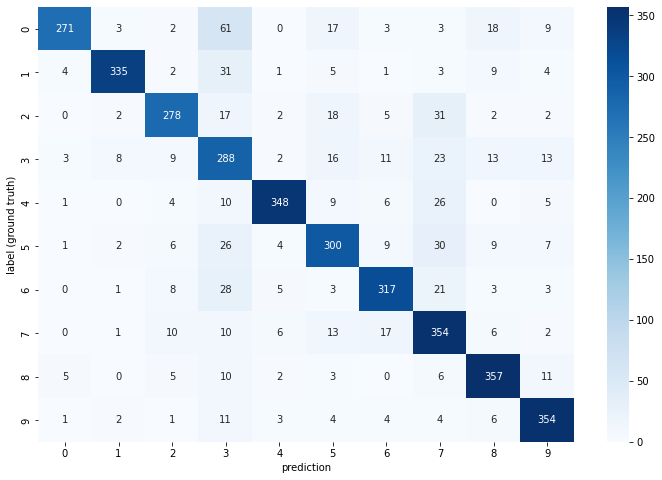

Acc of 0: 0.7003
Acc of 1: 0.8481
Acc of 2: 0.7787
Acc of 3: 0.7461
Acc of 4: 0.8509
Acc of 5: 0.7614
Acc of 6: 0.8149
Acc of 7: 0.8449
Acc of 8: 0.8947
Acc of 9: 0.9077

Total Acc: 0.815796178343949


In [24]:
hm.test(test_dataloader)

the latest trained is done using account: b03303028@gmail.com

# Reference
* [Section 8.4. Multi-Branch Networks (GoogLeNet)](http://d2l.ai/chapter_convolutional-modern/googlenet.html#multi-branch-networks-googlenet) from the book **Dive into Deep Learning** introduces Inception block and discuss the GoogLeNet from many aspects.
* A [blog post](https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7) from **Sik-Ho Tsang**'s Medium provides a great summary of the original paper.
* The [Tutorial 5](https://meetonfriday.com/posts/a151bfa2/) from the **UvA Deep Learning Tutorials** presents details to construct a Inception module using Pytorch.